# Introduction 

In this notebook I made some experiements with EfficientNet (https://doi.org/10.48550/arXiv.1905.11946). I compared resnet50 against efficientnetB0 on imagenet320 dateset and a Facial Image Recognition (FER) dataset. For both models, I used the torchvision.models. In the transferlearning case, I used the models weights pretrained on ImageNet. The goal was to compare prediction performance, training time and number of parameters of both models. 

# Imagenette 320 Test

## Data

I'll use the Imagenette data set during this test. More specifically, I'll use the Imagenette-320 data set. Imagenette is a very small subset of the Imagenet data set which consists of 9469 training samples and 3925 validation examples. Each sample is a 320x320 image, associated with a label from 10 different classes. More information can be found [here](https://github.com/fastai/imagenette)

You can download the dataset [here](https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz)

Labels:</br>
0=n01440764='tench',</br>
1=n02102040='English springer',</br>
2=n02979186='cassette player',</br>
3=n03000684='chain saw',</br>
4=n03028079='church',</br>
5=n03394916='French horn',</br>
6=n03417042='garbage truck',</br>
7=n03425413='gas pump',</br>
8=n03445777='golf ball',</br>
9=n03888257='parachute'</br>


## Helper Functions

In [ ]:
def output_label(label):
    '''This function is able to translate the numerical class label into the corresponding noun. '''
    output_mapping = {
                 0: "tench",
                 1: "English springer",
                 2: "caseete player",
                 3: "chain saw",
                 4: "church", 
                 5: "French horn", 
                 6: "garbage truck",
                 7: "gas pump",
                 8: "golf ball",
                 9: "parachute"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
import torch

print(torch.cuda.is_available())
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing


In [ ]:
transformer_train = transforms.Compose([transforms.Resize((224,224)),
                                  transforms.RandomApply(transforms = [
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(25),
                                    transforms.RandomAutocontrast(p=0.3),
                                    transforms.RandomInvert(p=0.5),
                                    transforms.ColorJitter(brightness =.5), #  contrast=.1, hue=.2, saturation=.2
                                    transforms.RandomAffine(degrees=0,translate=(0.01, 0.12),shear=(0.01, 0.03))] , p=0.7),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 










transformer_test = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                  ]) 



train = torchvision.datasets.ImageFolder('imagenette320/train', transform = transformer_train)
val = torchvision.datasets.ImageFolder('imagenette320/val', transform = transformer_test)

In [ ]:
from collections import Counter
import plotly.express as px

print(dict(Counter(train.targets)))

fig = px.bar(x = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"],    
             y = dict(Counter(train.targets)).values() , 
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

{0: 963, 1: 955, 2: 993, 3: 858, 4: 941, 5: 956, 6: 961, 7: 931, 8: 951, 9: 960}


In [ ]:
train_dl = torch.utils.data.DataLoader(train, batch_size=64, shuffle = True, num_workers=8, prefetch_factor=6)
valid_dl = torch.utils.data.DataLoader(val, batch_size=64, shuffle = True, num_workers=8, prefetch_factor=6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


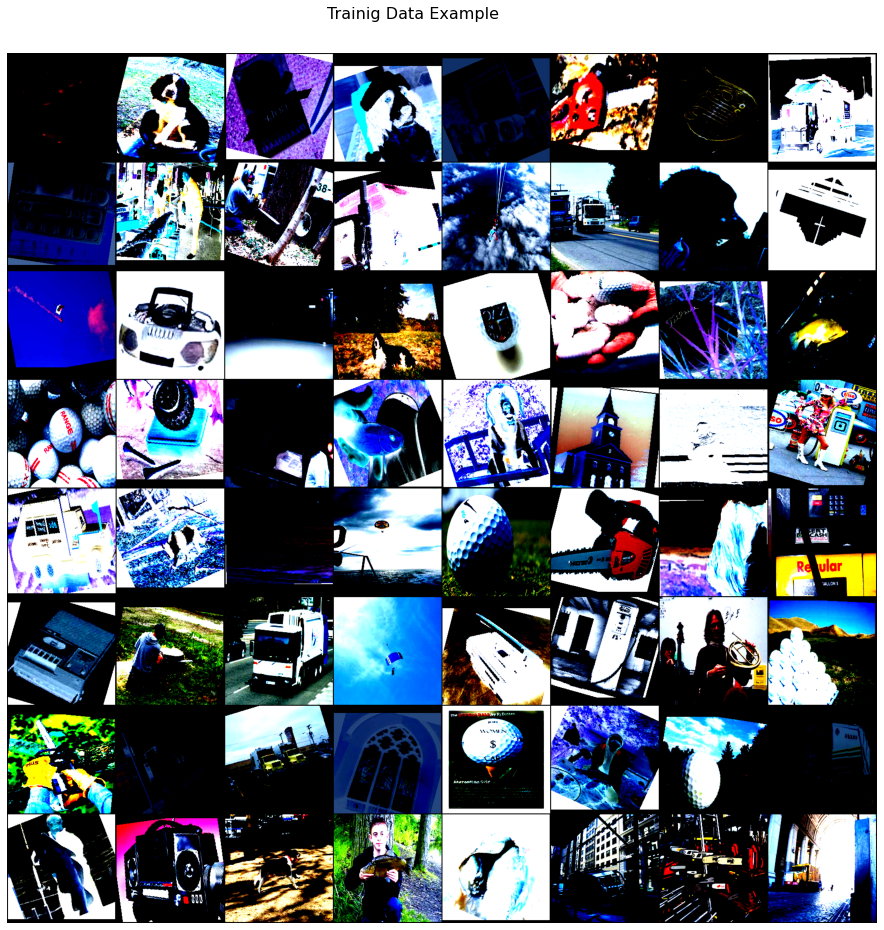

In [ ]:
from torchvision.utils import make_grid

for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(32,16))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Trainig Data Example", y=0.92, fontsize=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


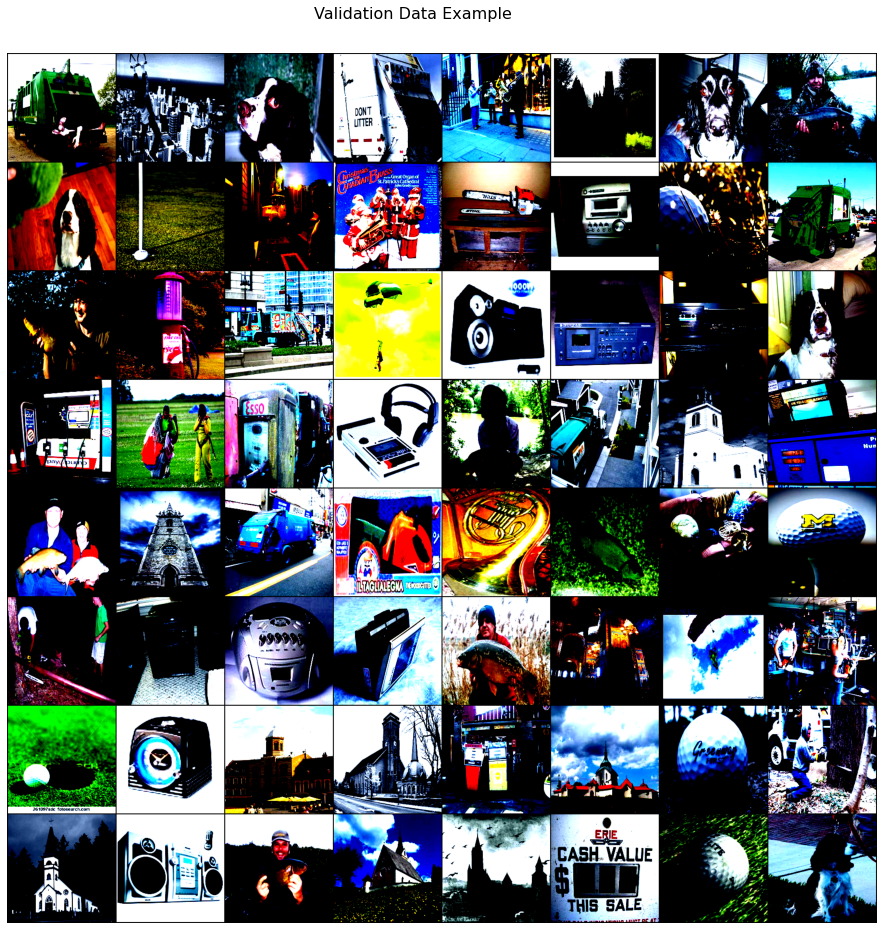

In [ ]:
from torchvision.utils import make_grid

for images, _ in valid_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(32,16))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Validation Data Example", y=0.92, fontsize=16)

## Model Building

In [ ]:
from torchvision.models import  resnet50, efficientnet_b0
resnet50_fine_model = resnet50(pretrained=True)
efficientnet_b0_fine_model = efficientnet_b0(pretrained=True)

resnet50_base_model = resnet50(pretrained=False)
efficientnet_b0_base_model = efficientnet_b0(pretrained=False)



## Model Training

In [ ]:
from torch import optim
import torch.nn.functional as F
from torch import nn


In [ ]:
from tqdm import tqdm


def training(net, n_epochs, optimizer, loss_function, train_dl, verbose=True, patience = 4):
  # Store the losses for each epoch
  loss_train_list = []
  loss_valid_list = []

  # Store the accuracy for each epoch
  acc_train_list = []
  acc_valid_list = []

  # needed for stopping
  the_last_loss = 0
  trigger_times = 0 

  import time
  training_start_time = time.time() # to know how long each epoch takes

  # Iterate over the dataset n_epochs times
  for epoch in tqdm(range(n_epochs)):
    net.train()  # net.train() will notify all your layers that you are in training mode

    train_loss = 0  # Training loss in epoch
    num_train_correct  = 0
    num_train_examples = 0

    # For each batch, pass the training examples, calculate loss and gradients and optimize the parameters
    for xb, yb in train_dl:
      optimizer.zero_grad()  # zero_grad clears old gradients from the last step

      xb = xb.to(device)
      yb = yb.to(device)

      y_hat = net(xb)  # Forward pass
      loss = loss_function(y_hat, yb)  # Calculate Loss
      
      loss.backward()  # Calculate the gradients (using backpropagation)
      optimizer.step()  # # Optimize the parameters: opt.step() causes the optimizer to take a step based on the gradients of the parameters.
      
      
      train_loss += loss.item()
      num_train_correct += (torch.max(y_hat, 1)[1] == yb).sum().item()
      num_train_examples += xb.shape[0]
    
    train_acc = num_train_correct / num_train_examples
    
    valid_loss = 0  # Validation loss in epoch
    num_val_correct  = 0
    num_val_examples = 0

    net.eval()  
    # torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed 
    # up computations but you won’t be able to backprop (which you don’t want in an evaluation script).
    with torch.no_grad():
      # Perform a prediction on the validation set  
      for xb_valid, yb_valid in valid_dl:
        xb_valid = xb_valid.to(device)
        yb_valid = yb_valid.to(device)

        y_hat = net(xb_valid)  # Forward pass
        loss = loss_function(y_hat, yb_valid)  # Calculate Loss

        valid_loss += loss.item()
        num_val_correct += (torch.max(y_hat, 1)[1] == yb_valid).sum().item()
        num_val_examples += xb_valid.shape[0]
    
    val_acc = num_val_correct / num_val_examples

    #Early stopping
    the_current_loss = valid_loss

    if the_current_loss > the_last_loss:
      trigger_times += 1

      if trigger_times >= patience:
        print('Early stopping!')
        return acc_train_list, acc_valid_list, loss_train_list, loss_valid_list

    else:
      trigger_times = 0

    the_last_loss = the_current_loss
    

    if verbose:
    # print everything nicely
      print('Epoch: {} \t Total_Time: {:.2f} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
        epoch+1,
        (time.time() - training_start_time),
        train_loss,
        valid_loss,
        train_acc * 100,
        val_acc *100
        )) 

    loss_train_list.append(train_loss)
    loss_valid_list.append(valid_loss)
    acc_train_list.append(100 * (train_acc))
    acc_valid_list.append(100 * (val_acc))

  return acc_train_list, acc_valid_list, loss_train_list, loss_valid_list

In [ ]:
# change fc to 10 classes 
resnet50_fine_model.fc = nn.Linear(2048, 10)

# initalize otimizer 
optimizer = optim.Adam(resnet50_fine_model.parameters(), lr=0.0003)
epochs = 20

# Create Loss Function
loss_function = nn.CrossEntropyLoss()

# bring model to gpu 
resnet50_fine_model.to(device)

#start training 
res50_acc_train, res50_acc_valid, res_50_loss_train, res50_loss_valid = training(net=resnet50_fine_model, n_epochs=epochs, optimizer=optimizer, loss_function=loss_function, train_dl = train_dl)


torch.save(resnet50_fine_model.state_dict(), "saved_models/resnet50_fine_model.pth")



  5%|▌         | 1/20 [00:47<14:59, 47.34s/it]

Epoch: 1 	 Total_Time: 47.34 	Training Loss: 68.206081 	Validation Loss: 15.300057 	Training Acc: 86.387158 	Validation Acc: 92.662420


 10%|█         | 2/20 [01:30<13:32, 45.15s/it]

Epoch: 2 	 Total_Time: 90.96 	Training Loss: 43.858954 	Validation Loss: 20.864068 	Training Acc: 90.938853 	Validation Acc: 89.987261


 15%|█▌        | 3/20 [02:14<12:36, 44.49s/it]

Epoch: 3 	 Total_Time: 134.66 	Training Loss: 38.805119 	Validation Loss: 14.506233 	Training Acc: 91.921005 	Validation Acc: 92.611465


 20%|██        | 4/20 [02:58<11:47, 44.20s/it]

Epoch: 4 	 Total_Time: 178.43 	Training Loss: 33.049557 	Validation Loss: 13.096678 	Training Acc: 92.681381 	Validation Acc: 93.579618


 25%|██▌       | 5/20 [03:42<11:00, 44.02s/it]

Epoch: 5 	 Total_Time: 222.11 	Training Loss: 27.486017 	Validation Loss: 14.802340 	Training Acc: 94.107086 	Validation Acc: 92.764331


 30%|███       | 6/20 [04:25<10:15, 43.96s/it]

Epoch: 6 	 Total_Time: 265.96 	Training Loss: 25.369753 	Validation Loss: 14.790397 	Training Acc: 94.540078 	Validation Acc: 92.713376


 35%|███▌      | 7/20 [05:09<09:30, 43.90s/it]

Epoch: 7 	 Total_Time: 309.75 	Training Loss: 24.122893 	Validation Loss: 13.979457 	Training Acc: 95.078678 	Validation Acc: 93.732484


 40%|████      | 8/20 [05:53<08:47, 43.92s/it]

Epoch: 8 	 Total_Time: 353.71 	Training Loss: 21.442931 	Validation Loss: 17.197078 	Training Acc: 95.458866 	Validation Acc: 92.254777


 45%|████▌     | 9/20 [06:37<08:02, 43.91s/it]

Epoch: 9 	 Total_Time: 397.59 	Training Loss: 22.152389 	Validation Loss: 17.914025 	Training Acc: 95.332136 	Validation Acc: 92.356688


 50%|█████     | 10/20 [07:21<07:18, 43.87s/it]

Epoch: 10 	 Total_Time: 441.38 	Training Loss: 17.985599 	Validation Loss: 14.365410 	Training Acc: 96.166438 	Validation Acc: 93.222930


 55%|█████▌    | 11/20 [08:05<06:34, 43.87s/it]

Epoch: 11 	 Total_Time: 485.24 	Training Loss: 15.906147 	Validation Loss: 15.810207 	Training Acc: 96.567747 	Validation Acc: 93.248408


 60%|██████    | 12/20 [08:48<05:50, 43.83s/it]

Epoch: 12 	 Total_Time: 528.98 	Training Loss: 16.173495 	Validation Loss: 13.963947 	Training Acc: 96.441018 	Validation Acc: 94.012739


 65%|██████▌   | 13/20 [09:32<05:06, 43.80s/it]

Epoch: 13 	 Total_Time: 572.73 	Training Loss: 17.925073 	Validation Loss: 18.043336 	Training Acc: 96.388214 	Validation Acc: 92.789809


 70%|███████   | 14/20 [10:16<04:22, 43.76s/it]

Epoch: 14 	 Total_Time: 616.37 	Training Loss: 15.862701 	Validation Loss: 14.469214 	Training Acc: 96.557187 	Validation Acc: 92.917197


 75%|███████▌  | 15/20 [11:00<03:38, 43.74s/it]

Epoch: 15 	 Total_Time: 660.07 	Training Loss: 13.531317 	Validation Loss: 14.483102 	Training Acc: 97.233076 	Validation Acc: 93.222930


 80%|████████  | 16/20 [11:44<02:55, 43.91s/it]

Epoch: 16 	 Total_Time: 704.39 	Training Loss: 14.792046 	Validation Loss: 17.462920 	Training Acc: 96.652234 	Validation Acc: 92.535032


 85%|████████▌ | 17/20 [12:28<02:12, 44.02s/it]

Epoch: 17 	 Total_Time: 748.67 	Training Loss: 14.666429 	Validation Loss: 14.654693 	Training Acc: 96.705037 	Validation Acc: 93.070064


 90%|█████████ | 18/20 [13:13<01:28, 44.19s/it]

Epoch: 18 	 Total_Time: 793.23 	Training Loss: 15.132486 	Validation Loss: 13.635900 	Training Acc: 96.641673 	Validation Acc: 93.605096


 95%|█████████▌| 19/20 [13:57<00:44, 44.19s/it]

Epoch: 19 	 Total_Time: 837.42 	Training Loss: 10.654292 	Validation Loss: 14.313032 	Training Acc: 97.708311 	Validation Acc: 94.420382


100%|██████████| 20/20 [14:41<00:00, 44.08s/it]

Epoch: 20 	 Total_Time: 881.61 	Training Loss: 11.979819 	Validation Loss: 14.878546 	Training Acc: 97.264759 	Validation Acc: 93.808917


In [ ]:
# change fc to 10 classes 
resnet50_base_model.fc = nn.Linear(2048, 10)

# initalize otimizer 
optimizer = optim.Adam(resnet50_base_model.parameters(), lr=0.0003)
epochs = 20

# Create Loss Function
loss_function = nn.CrossEntropyLoss()

# bring model to gpu 
resnet50_base_model.to(device)

#start training 
base_res50_acc_train, base_res50_acc_valid, base_res_50_loss_train, base_res50_loss_valid = training(net=resnet50_base_model, n_epochs=epochs, optimizer=optimizer, loss_function=loss_function, train_dl = train_dl)


torch.save(resnet50_base_model.state_dict(), "saved_models/resnet50_base_model.pth")

  5%|▌         | 1/20 [00:44<14:02, 44.34s/it]

Epoch: 1 	 Total_Time: 44.34 	Training Loss: 317.397719 	Validation Loss: 110.989986 	Training Acc: 23.265392 	Validation Acc: 38.980892


 10%|█         | 2/20 [01:28<13:16, 44.25s/it]

Epoch: 2 	 Total_Time: 88.52 	Training Loss: 269.436813 	Validation Loss: 99.702052 	Training Acc: 37.353469 	Validation Acc: 47.235669


 15%|█▌        | 3/20 [02:12<12:30, 44.16s/it]

Epoch: 3 	 Total_Time: 132.59 	Training Loss: 238.993380 	Validation Loss: 93.733794 	Training Acc: 45.083958 	Validation Acc: 50.420382


 20%|██        | 4/20 [02:56<11:46, 44.18s/it]

Epoch: 4 	 Total_Time: 176.80 	Training Loss: 216.520594 	Validation Loss: 82.209506 	Training Acc: 50.892386 	Validation Acc: 57.121019


 25%|██▌       | 5/20 [03:40<11:02, 44.16s/it]

Epoch: 5 	 Total_Time: 220.91 	Training Loss: 197.663210 	Validation Loss: 79.486298 	Training Acc: 55.380716 	Validation Acc: 59.617834


 30%|███       | 6/20 [04:25<10:18, 44.18s/it]

Epoch: 6 	 Total_Time: 265.15 	Training Loss: 183.624776 	Validation Loss: 69.217983 	Training Acc: 59.024184 	Validation Acc: 64.127389


 35%|███▌      | 7/20 [05:09<09:34, 44.18s/it]

Epoch: 7 	 Total_Time: 309.31 	Training Loss: 169.279532 	Validation Loss: 77.959096 	Training Acc: 62.245221 	Validation Acc: 60.152866


 40%|████      | 8/20 [05:53<08:50, 44.19s/it]

Epoch: 8 	 Total_Time: 353.54 	Training Loss: 156.879457 	Validation Loss: 62.810748 	Training Acc: 65.487380 	Validation Acc: 66.802548


 45%|████▌     | 9/20 [06:37<08:06, 44.19s/it]

Epoch: 9 	 Total_Time: 397.71 	Training Loss: 151.489061 	Validation Loss: 60.154554 	Training Acc: 66.247756 	Validation Acc: 69.044586


 50%|█████     | 10/20 [07:21<07:21, 44.18s/it]

Epoch: 10 	 Total_Time: 441.86 	Training Loss: 138.487068 	Validation Loss: 57.750237 	Training Acc: 68.993558 	Validation Acc: 70.700637


 55%|█████▌    | 11/20 [08:06<06:37, 44.19s/it]

Epoch: 11 	 Total_Time: 486.08 	Training Loss: 130.988953 	Validation Loss: 82.023694 	Training Acc: 70.714965 	Validation Acc: 62.573248


 60%|██████    | 12/20 [08:50<05:53, 44.19s/it]

Epoch: 12 	 Total_Time: 530.27 	Training Loss: 126.603852 	Validation Loss: 55.878072 	Training Acc: 71.507023 	Validation Acc: 72.942675


 65%|██████▌   | 13/20 [09:34<05:09, 44.25s/it]

Epoch: 13 	 Total_Time: 574.66 	Training Loss: 120.018834 	Validation Loss: 48.547858 	Training Acc: 73.154504 	Validation Acc: 75.592357


 70%|███████   | 14/20 [10:18<04:25, 44.23s/it]

Epoch: 14 	 Total_Time: 618.84 	Training Loss: 115.895730 	Validation Loss: 62.536799 	Training Acc: 74.009927 	Validation Acc: 69.579618


 75%|███████▌  | 15/20 [11:03<03:41, 44.22s/it]

Epoch: 15 	 Total_Time: 663.03 	Training Loss: 110.965494 	Validation Loss: 47.109492 	Training Acc: 74.960397 	Validation Acc: 76.535032


 80%|████████  | 16/20 [11:47<02:56, 44.20s/it]

Epoch: 16 	 Total_Time: 707.19 	Training Loss: 103.243921 	Validation Loss: 45.766850 	Training Acc: 76.914141 	Validation Acc: 76.993631


 85%|████████▌ | 17/20 [12:31<02:12, 44.15s/it]

Epoch: 17 	 Total_Time: 751.22 	Training Loss: 102.338888 	Validation Loss: 44.208710 	Training Acc: 77.093674 	Validation Acc: 78.114650


 90%|█████████ | 18/20 [13:15<01:28, 44.21s/it]

Epoch: 18 	 Total_Time: 795.57 	Training Loss: 97.949006 	Validation Loss: 42.378765 	Training Acc: 77.927975 	Validation Acc: 78.496815


 95%|█████████▌| 19/20 [13:59<00:44, 44.26s/it]

Epoch: 19 	 Total_Time: 839.94 	Training Loss: 92.539386 	Validation Loss: 41.500760 	Training Acc: 79.543774 	Validation Acc: 79.439490


100%|██████████| 20/20 [14:43<00:00, 44.19s/it]

Epoch: 20 	 Total_Time: 883.84 	Training Loss: 91.493236 	Validation Loss: 52.083805 	Training Acc: 79.364241 	Validation Acc: 74.649682


In [ ]:
# change fc to 10 classes 
efficientnet_b0_fine_model.fc = nn.Linear(512, 10)


# initalize otimizer 
optimizer = optim.Adam(efficientnet_b0_fine_model.parameters(), lr=0.0003)
epochs = 20

# Create Loss Function
loss_function = nn.CrossEntropyLoss()

# bring model to gpu 
efficientnet_b0_fine_model.to(device)

#start training 
eff_acc_train, eff_acc_valid, eff_loss_train, eff_loss_valid = training(net=efficientnet_b0_fine_model, n_epochs=epochs, optimizer=optimizer, loss_function=loss_function, train_dl = train_dl)

torch.save(efficientnet_b0_fine_model.state_dict(), "saved_models/efficientnet_b0_fine_model.pth")


  5%|▌         | 1/20 [00:33<10:42, 33.83s/it]

Epoch: 1 	 Total_Time: 33.83 	Training Loss: 113.120707 	Validation Loss: 4.034735 	Training Acc: 85.837998 	Validation Acc: 98.038217


 10%|█         | 2/20 [01:07<10:03, 33.53s/it]

Epoch: 2 	 Total_Time: 67.16 	Training Loss: 15.568604 	Validation Loss: 3.298190 	Training Acc: 96.852888 	Validation Acc: 98.522293


 15%|█▌        | 3/20 [01:40<09:32, 33.66s/it]

Epoch: 3 	 Total_Time: 100.98 	Training Loss: 10.757423 	Validation Loss: 2.868603 	Training Acc: 97.718872 	Validation Acc: 98.598726


 20%|██        | 4/20 [02:14<08:57, 33.60s/it]

Epoch: 4 	 Total_Time: 134.47 	Training Loss: 8.356775 	Validation Loss: 3.723834 	Training Acc: 98.384201 	Validation Acc: 98.343949


 25%|██▌       | 5/20 [02:48<08:25, 33.70s/it]

Epoch: 5 	 Total_Time: 168.35 	Training Loss: 7.056768 	Validation Loss: 2.678649 	Training Acc: 98.426444 	Validation Acc: 98.726115


 30%|███       | 6/20 [03:21<07:50, 33.64s/it]

Epoch: 6 	 Total_Time: 201.87 	Training Loss: 5.620359 	Validation Loss: 2.995671 	Training Acc: 98.753828 	Validation Acc: 98.726115


 35%|███▌      | 7/20 [03:55<07:16, 33.55s/it]

Epoch: 7 	 Total_Time: 235.25 	Training Loss: 5.464986 	Validation Loss: 4.371939 	Training Acc: 98.838314 	Validation Acc: 97.987261


 40%|████      | 8/20 [04:28<06:43, 33.61s/it]

Epoch: 8 	 Total_Time: 268.98 	Training Loss: 5.658608 	Validation Loss: 3.600212 	Training Acc: 98.796071 	Validation Acc: 98.420382


 45%|████▌     | 9/20 [05:02<06:08, 33.53s/it]

Epoch: 9 	 Total_Time: 302.33 	Training Loss: 6.128230 	Validation Loss: 4.011143 	Training Acc: 98.732707 	Validation Acc: 98.496815


 50%|█████     | 10/20 [05:35<05:35, 33.54s/it]

Epoch: 10 	 Total_Time: 335.91 	Training Loss: 6.189798 	Validation Loss: 3.433349 	Training Acc: 98.817193 	Validation Acc: 98.496815


 55%|█████▌    | 11/20 [06:09<05:02, 33.56s/it]

Epoch: 11 	 Total_Time: 369.50 	Training Loss: 3.755864 	Validation Loss: 3.448698 	Training Acc: 99.260746 	Validation Acc: 98.394904


 60%|██████    | 12/20 [06:43<04:28, 33.57s/it]

Epoch: 12 	 Total_Time: 403.09 	Training Loss: 3.992208 	Validation Loss: 5.106526 	Training Acc: 99.176259 	Validation Acc: 98.114650


 65%|██████▌   | 13/20 [07:16<03:55, 33.57s/it]

Epoch: 13 	 Total_Time: 436.68 	Training Loss: 5.996203 	Validation Loss: 4.410086 	Training Acc: 98.753828 	Validation Acc: 98.038217


 70%|███████   | 14/20 [07:50<03:20, 33.50s/it]

Epoch: 14 	 Total_Time: 470.00 	Training Loss: 4.235674 	Validation Loss: 4.251987 	Training Acc: 99.102334 	Validation Acc: 98.114650


 75%|███████▌  | 15/20 [08:23<02:47, 33.49s/it]

Epoch: 15 	 Total_Time: 503.47 	Training Loss: 4.284020 	Validation Loss: 3.829721 	Training Acc: 99.229063 	Validation Acc: 98.292994


 80%|████████  | 16/20 [08:56<02:13, 33.44s/it]

Epoch: 16 	 Total_Time: 536.79 	Training Loss: 2.492183 	Validation Loss: 4.471366 	Training Acc: 99.429718 	Validation Acc: 98.191083


 85%|████████▌ | 17/20 [09:30<01:40, 33.50s/it]

Epoch: 17 	 Total_Time: 570.43 	Training Loss: 2.838553 	Validation Loss: 5.467555 	Training Acc: 99.355793 	Validation Acc: 97.987261


 90%|█████████ | 18/20 [10:04<01:07, 33.54s/it]

Epoch: 18 	 Total_Time: 604.06 	Training Loss: 3.117318 	Validation Loss: 4.208933 	Training Acc: 99.313549 	Validation Acc: 98.165605


 95%|█████████▌| 19/20 [10:37<00:33, 33.61s/it]

Epoch: 19 	 Total_Time: 637.85 	Training Loss: 3.763015 	Validation Loss: 5.166110 	Training Acc: 99.229063 	Validation Acc: 97.885350


100%|██████████| 20/20 [11:11<00:00, 33.59s/it]

Epoch: 20 	 Total_Time: 671.86 	Training Loss: 4.112022 	Validation Loss: 4.717859 	Training Acc: 99.165699 	Validation Acc: 98.140127


In [ ]:
# change fc to 10 classes 
efficientnet_b0_base_model.fc = nn.Linear(512, 10)


# initalize otimizer 
optimizer = optim.Adam(efficientnet_b0_base_model.parameters(), lr=0.0003)
epochs = 20

# Create Loss Function
loss_function = nn.CrossEntropyLoss()

# bring model to gpu 
efficientnet_b0_base_model.to(device)

#start training 
base_eff_acc_train, base_eff_acc_valid, base_eff_loss_train, base_eff_loss_valid = training(net=efficientnet_b0_base_model, n_epochs=epochs, optimizer=optimizer, loss_function=loss_function, train_dl = train_dl)

torch.save(efficientnet_b0_base_model.state_dict(), "saved_models/efficientnet_b0_base_model.pth")


  5%|▌         | 1/20 [00:33<10:40, 33.69s/it]

Epoch: 1 	 Total_Time: 33.69 	Training Loss: 422.247527 	Validation Loss: 117.470128 	Training Acc: 19.928187 	Validation Acc: 33.834395


 10%|█         | 2/20 [01:07<10:09, 33.84s/it]

Epoch: 2 	 Total_Time: 67.64 	Training Loss: 277.375291 	Validation Loss: 97.468345 	Training Acc: 34.206358 	Validation Acc: 46.242038


 15%|█▌        | 3/20 [01:41<09:37, 34.00s/it]

Epoch: 3 	 Total_Time: 101.83 	Training Loss: 250.576093 	Validation Loss: 92.764813 	Training Acc: 41.134227 	Validation Acc: 50.343949


 20%|██        | 4/20 [02:15<09:04, 34.04s/it]

Epoch: 4 	 Total_Time: 135.92 	Training Loss: 228.455767 	Validation Loss: 81.255868 	Training Acc: 47.259478 	Validation Acc: 57.350318


 25%|██▌       | 5/20 [02:49<08:28, 33.92s/it]

Epoch: 5 	 Total_Time: 169.62 	Training Loss: 209.397759 	Validation Loss: 71.892551 	Training Acc: 52.370894 	Validation Acc: 62.420382


 30%|███       | 6/20 [03:23<07:54, 33.87s/it]

Epoch: 6 	 Total_Time: 203.41 	Training Loss: 191.755071 	Validation Loss: 69.028613 	Training Acc: 56.774739 	Validation Acc: 63.821656


 35%|███▌      | 7/20 [03:57<07:20, 33.90s/it]

Epoch: 7 	 Total_Time: 237.37 	Training Loss: 177.898553 	Validation Loss: 60.300307 	Training Acc: 60.249234 	Validation Acc: 68.713376


 40%|████      | 8/20 [04:31<06:46, 33.87s/it]

Epoch: 8 	 Total_Time: 271.18 	Training Loss: 169.225803 	Validation Loss: 59.974705 	Training Acc: 62.435315 	Validation Acc: 67.974522


 45%|████▌     | 9/20 [05:05<06:12, 33.90s/it]

Epoch: 9 	 Total_Time: 305.15 	Training Loss: 158.201434 	Validation Loss: 56.335259 	Training Acc: 64.906537 	Validation Acc: 70.751592


 50%|█████     | 10/20 [05:38<05:38, 33.88s/it]

Epoch: 10 	 Total_Time: 338.98 	Training Loss: 149.976336 	Validation Loss: 51.303527 	Training Acc: 66.258317 	Validation Acc: 73.783439


 55%|█████▌    | 11/20 [06:12<05:04, 33.86s/it]

Epoch: 11 	 Total_Time: 372.79 	Training Loss: 141.423453 	Validation Loss: 51.790785 	Training Acc: 68.602809 	Validation Acc: 72.993631


 60%|██████    | 12/20 [06:46<04:31, 33.89s/it]

Epoch: 12 	 Total_Time: 406.76 	Training Loss: 134.454169 	Validation Loss: 47.482047 	Training Acc: 70.017953 	Validation Acc: 74.751592


 65%|██████▌   | 13/20 [07:20<03:56, 33.78s/it]

Epoch: 13 	 Total_Time: 440.27 	Training Loss: 127.323684 	Validation Loss: 49.811874 	Training Acc: 71.274686 	Validation Acc: 74.191083


 70%|███████   | 14/20 [07:54<03:23, 33.87s/it]

Epoch: 14 	 Total_Time: 474.36 	Training Loss: 122.318741 	Validation Loss: 46.823477 	Training Acc: 73.017214 	Validation Acc: 75.414013


 75%|███████▌  | 15/20 [08:28<02:49, 33.88s/it]

Epoch: 15 	 Total_Time: 508.26 	Training Loss: 117.309703 	Validation Loss: 44.310325 	Training Acc: 73.640300 	Validation Acc: 77.401274


 80%|████████  | 16/20 [09:02<02:15, 33.94s/it]

Epoch: 16 	 Total_Time: 542.33 	Training Loss: 110.292829 	Validation Loss: 41.534203 	Training Acc: 75.435632 	Validation Acc: 78.394904


 85%|████████▌ | 17/20 [09:36<01:41, 33.88s/it]

Epoch: 17 	 Total_Time: 576.07 	Training Loss: 105.672107 	Validation Loss: 39.930454 	Training Acc: 76.491710 	Validation Acc: 79.286624


 90%|█████████ | 18/20 [10:09<01:07, 33.81s/it]

Epoch: 18 	 Total_Time: 609.72 	Training Loss: 103.225404 	Validation Loss: 42.434553 	Training Acc: 77.135917 	Validation Acc: 77.146497


 95%|█████████▌| 19/20 [10:43<00:33, 33.80s/it]

Epoch: 19 	 Total_Time: 643.50 	Training Loss: 99.775559 	Validation Loss: 39.341972 	Training Acc: 77.801246 	Validation Acc: 79.566879


100%|██████████| 20/20 [11:17<00:00, 33.87s/it]

Epoch: 20 	 Total_Time: 677.40 	Training Loss: 95.160882 	Validation Loss: 39.086131 	Training Acc: 78.836202 	Validation Acc: 80.050955


## Model Evaluation

### Number of parameters

In [ ]:
# Number of parameters that require training 
ResNet50_total_params = sum(p.numel() for p in resnet50_fine_model.parameters() if p.requires_grad)
EffNet_total_params = sum(p.numel() for p in efficientnet_b0_fine_model.parameters() if p.requires_grad)

print(f"Pretrained ResNet50 number of parameters that require training: {ResNet50_total_params} ")
print(f"Pretrained EfficientNetB0 number of parameters that require training: {EffNet_total_params}")
print(f"Pretrained ResNet50 requires: {round(ResNet50_total_params / EffNet_total_params, 2)} times the amount of parameters to be trained")

base_ResNet50_total_params = sum(p.numel() for p in resnet50_base_model.parameters() if p.requires_grad)
base_EffNet_total_params = sum(p.numel() for p in efficientnet_b0_base_model.parameters() if p.requires_grad)

print(f"Base ResNet50 number of parameters that require training: {base_ResNet50_total_params} ")
print(f"Base EfficientNetB0 number of parameters that require training: {base_EffNet_total_params}")
print(f"Base ResNet50 requires: {round(base_ResNet50_total_params / base_EffNet_total_params, 2)} times the amount of parameters to be trained")


Pretrained ResNet50 number of parameters that require training: 23528522 
Pretrained EfficientNetB0 number of parameters that require training: 5293678
Pretrained ResNet50 requires: 4.44 times the amount of parameters to be trained
Base ResNet50 number of parameters that require training: 23528522 
Base EfficientNetB0 number of parameters that require training: 5293678
Base ResNet50 requires: 4.44 times the amount of parameters to be trained


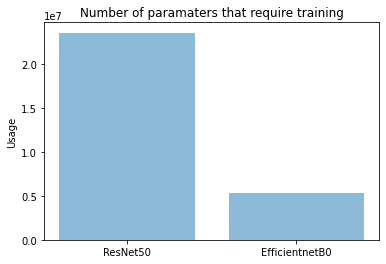

In [ ]:
# Plot number of parameters that require training: 

objects = ('ResNet50', 'EfficientnetB0')
y_pos = np.arange(len(objects))
performance = [ResNet50_total_params, EffNet_total_params]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Number of paramaters that require training')
plt.show()




### Loss and accuracy analysis

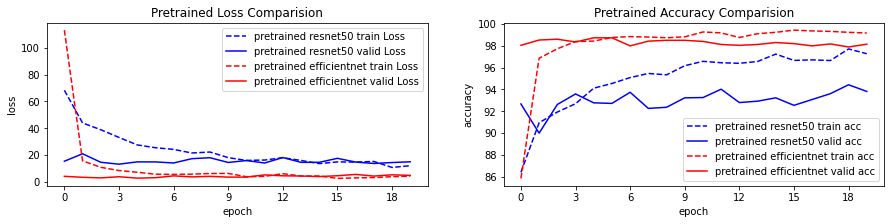

In [ ]:
import matplotlib.ticker as ticker

# Plot Loss and Accuracy over Epochs 

f = plt.figure(figsize=(15,3))


ax = f.add_subplot(121)
plt.plot(res_50_loss_train, label='pretrained resnet50 train Loss', color= "blue", ls = "--")
plt.plot(res50_loss_valid, label='pretrained resnet50 valid Loss', color= "blue")
plt.plot(eff_loss_train, label='pretrained efficientnet train Loss', color= "red", ls = "--")
plt.plot(eff_loss_valid, label='pretrained efficientnet valid Loss', color= "red")
plt.title("Pretrained Loss Comparision")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

ax = f.add_subplot(122)
plt.plot(res50_acc_train, label='pretrained resnet50 train acc', color= "blue", ls = "--")
plt.plot(res50_acc_valid, label='pretrained resnet50 valid acc', color= "blue")
plt.plot(eff_acc_train, label='pretrained efficientnet train acc', color= "red", ls = "--")
plt.plot(eff_acc_valid, label='pretrained efficientnet valid acc', color= "red")
plt.title("Pretrained Accuracy Comparision")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

#format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()


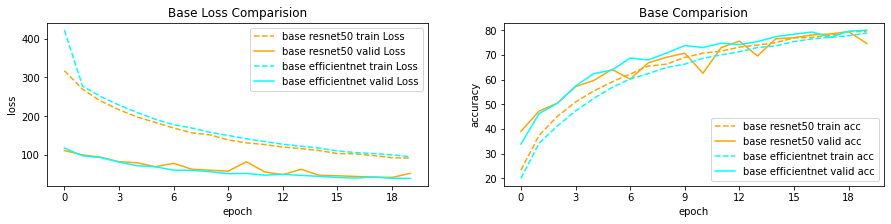

In [ ]:
import matplotlib.ticker as ticker

# Plot Loss and Accuracy over Epochs 

f = plt.figure(figsize=(15,3))


ax = f.add_subplot(121)
plt.plot(base_res_50_loss_train, label='base resnet50 train Loss', color= "orange", ls = "--")
plt.plot(base_res50_loss_valid, label='base resnet50 valid Loss', color= "orange")
plt.plot(base_eff_loss_train, label='base efficientnet train Loss', color= "cyan", ls = "--")
plt.plot(base_eff_loss_valid, label='base efficientnet valid Loss', color= "cyan")
plt.title("Base Loss Comparision")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

ax = f.add_subplot(122)
plt.plot(base_res50_acc_train, label='base resnet50 train acc', color= "orange", ls = "--")
plt.plot(base_res50_acc_valid, label='base resnet50 valid acc', color= "orange")
plt.plot(base_eff_acc_train, label='base efficientnet train acc', color= "cyan", ls = "--")
plt.plot(base_eff_acc_valid, label='base efficientnet valid acc', color= "cyan")
plt.title("Base Comparision")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

#format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

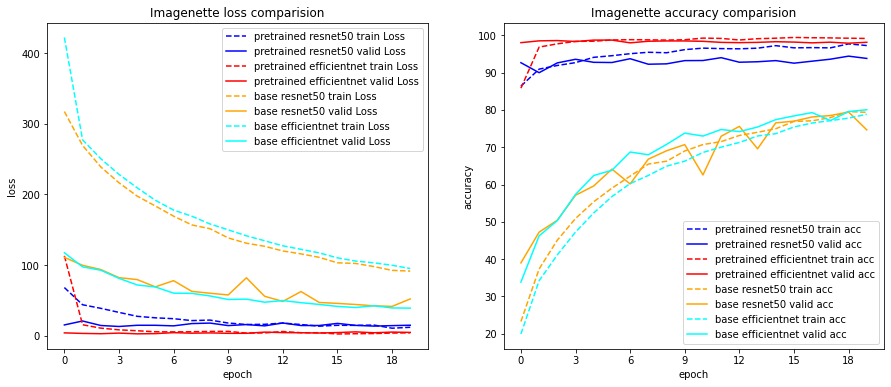

In [ ]:
import matplotlib.ticker as ticker

# Plot Loss and Accuracy over Epochs 

f = plt.figure(figsize=(15,6))


ax = f.add_subplot(121)

plt.plot(res_50_loss_train, label='pretrained resnet50 train Loss', color= "blue", ls = "--")
plt.plot(res50_loss_valid, label='pretrained resnet50 valid Loss', color= "blue")
plt.plot(eff_loss_train, label='pretrained efficientnet train Loss', color= "red", ls = "--")
plt.plot(eff_loss_valid, label='pretrained efficientnet valid Loss', color= "red")

plt.plot(base_res_50_loss_train, label='base resnet50 train Loss', color= "orange", ls = "--")
plt.plot(base_res50_loss_valid, label='base resnet50 valid Loss', color= "orange")
plt.plot(base_eff_loss_train, label='base efficientnet train Loss', color= "cyan", ls = "--")
plt.plot(base_eff_loss_valid, label='base efficientnet valid Loss', color= "cyan")
plt.title("Imagenette loss comparision")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

ax = f.add_subplot(122)

plt.plot(res50_acc_train, label='pretrained resnet50 train acc', color= "blue", ls = "--")
plt.plot(res50_acc_valid, label='pretrained resnet50 valid acc', color= "blue")
plt.plot(eff_acc_train, label='pretrained efficientnet train acc', color= "red", ls = "--")
plt.plot(eff_acc_valid, label='pretrained efficientnet valid acc', color= "red")

plt.plot(base_res50_acc_train, label='base resnet50 train acc', color= "orange", ls = "--")
plt.plot(base_res50_acc_valid, label='base resnet50 valid acc', color= "orange")
plt.plot(base_eff_acc_train, label='base efficientnet train acc', color= "cyan", ls = "--")
plt.plot(base_eff_acc_valid, label='base efficientnet valid acc', color= "cyan")
plt.title("Imagenette accuracy comparision")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

#format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

### Classification report 

In [ ]:
# get the correctly predicted lables 
def get_true_pred(model, data_loader, device = "cpu"):
  model.eval()  
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  y_pred = []
  y_true = []
  model.to(device)
  model.eval()  
  for x, y in data_loader:
    x, y = x.to(device), y.to(device) 
    output = model(x)
    _, pred = torch.max(output, 1)
    y_pred.append(pred.tolist())
    y_true.append(y.tolist())
    
  y_true_flat = [item for sublist in y_true for item in sublist]
  y_pred_flat = [item for sublist in y_pred for item in sublist]
  
  torch.cuda.empty_cache()  
    
  return y_true_flat, y_pred_flat

In [ ]:
res_50_y_true, res_50_y_pred = get_true_pred(resnet50_fine_model, valid_dl)
from sklearn.metrics import classification_report

target_names = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]
print("Pretrained Resnet50")
print(classification_report(res_50_y_true, res_50_y_pred, target_names=target_names))

Pretrained Resnet50
                  precision    recall  f1-score   support

           tench       0.95      0.98      0.97       387
English springer       0.99      0.97      0.98       395
 cassette player       0.95      0.95      0.95       357
       chain saw       0.92      0.89      0.90       386
          church       0.95      0.96      0.96       409
     French horn       0.97      0.95      0.96       394
   garbage truck       0.97      0.97      0.97       389
        gas pump       0.87      0.96      0.91       419
       golf ball       0.99      0.95      0.97       399
       parachute       0.96      0.93      0.94       390

        accuracy                           0.95      3925
       macro avg       0.95      0.95      0.95      3925
    weighted avg       0.95      0.95      0.95      3925



In [ ]:
eff_50_y_true, eff_50_y_pred = get_true_pred(efficientnet_b0_fine_model, valid_dl)
from sklearn.metrics import classification_report

target_names = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]
print("Pretrained Efficientnet")
print(classification_report(eff_50_y_true, eff_50_y_pred, target_names=target_names))

Pretrained Efficientnet
                  precision    recall  f1-score   support

           tench       1.00      0.99      1.00       387
English springer       0.99      0.99      0.99       395
 cassette player       0.98      0.97      0.98       357
       chain saw       0.96      0.98      0.97       386
          church       0.97      0.99      0.98       409
     French horn       0.98      0.98      0.98       394
   garbage truck       0.98      0.97      0.98       389
        gas pump       0.98      0.97      0.97       419
       golf ball       0.99      0.99      0.99       399
       parachute       0.99      0.98      0.99       390

        accuracy                           0.98      3925
       macro avg       0.98      0.98      0.98      3925
    weighted avg       0.98      0.98      0.98      3925



In [ ]:
res_50_y_true, res_50_y_pred = get_true_pred(resnet50_base_model, valid_dl)
from sklearn.metrics import classification_report

target_names = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]
print("Base Resnet50")
print(classification_report(res_50_y_true, res_50_y_pred, target_names=target_names))

Base Resnet50
                  precision    recall  f1-score   support

           tench       0.83      0.88      0.85       387
English springer       0.85      0.82      0.83       395
 cassette player       0.48      0.93      0.64       357
       chain saw       0.61      0.61      0.61       386
          church       0.95      0.58      0.72       409
     French horn       0.83      0.71      0.77       394
   garbage truck       0.89      0.61      0.72       389
        gas pump       0.82      0.63      0.71       419
       golf ball       0.71      0.78      0.74       399
       parachute       0.73      0.85      0.79       390

        accuracy                           0.74      3925
       macro avg       0.77      0.74      0.74      3925
    weighted avg       0.77      0.74      0.74      3925



In [ ]:
eff_50_y_true, eff_50_y_pred = get_true_pred(efficientnet_b0_base_model, valid_dl)
from sklearn.metrics import classification_report

target_names = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]
print("Base Efficientnet")
print(classification_report(eff_50_y_true, eff_50_y_pred, target_names=target_names))

Base Efficientnet
                  precision    recall  f1-score   support

           tench       0.92      0.85      0.88       387
English springer       0.86      0.86      0.86       395
 cassette player       0.68      0.88      0.77       357
       chain saw       0.71      0.68      0.69       386
          church       0.71      0.90      0.79       409
     French horn       0.86      0.71      0.77       394
   garbage truck       0.83      0.78      0.80       389
        gas pump       0.75      0.75      0.75       419
       golf ball       0.83      0.72      0.77       399
       parachute       0.87      0.83      0.85       390

        accuracy                           0.79      3925
       macro avg       0.80      0.79      0.79      3925
    weighted avg       0.80      0.79      0.79      3925



# Facial Emotion Recognition Transfer Learning Test

## Load Data

I'll use a facial image recognition dataset, that I got to know in the couse artifical information management by Prof. Schoder at University of Cologne. 

The dataset consits of 9108 images of faces. Most of the images have the size 100x100 pixels. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The challenge is to categorize each face based on the emotion shown in the facial expression into one of five categories (Angry, Fear, Happy, Sad, Surprise)

You can find the data [here](https://uni-koeln.sciebo.de/s/vPcXOe9uIyiuo2G).  

## Helper functions

In [ ]:
def output_label2(label):
    '''This function is able to translate the numerical class label into the corresponding noun. '''
    output_mapping = {
                 0: "angry",
                 1: "fear",
                 2: "happy",
                 3: "sad",
                 4: "suprise"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
import torch

print(torch.cuda.is_available())
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
NVIDIA GeForce RTX 3080


In [ ]:
# Your code here
#!pip install split-folders
#import splitfolders
#input_folder = "FER_Data"

# Split with a ratio.
#splitfolders.ratio(input_folder, output="train_validation_test_split", 
#                   seed=42, ratio=(.7, .15, .15), 
#                   group_prefix=None) 

## Data Preprocessing


In [ ]:
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torchvision import *

In [ ]:
transformer_train = transforms.Compose([transforms.Resize((224,224)),
                                  transforms.RandomApply(transforms = [
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(25),
                                    transforms.RandomAutocontrast(p=0.3),
                                    transforms.RandomInvert(p=0.5),
                                    transforms.ColorJitter(brightness =.5), #  contrast=.1, hue=.2, saturation=.2
                                    transforms.RandomAffine(degrees=0,translate=(0.01, 0.12),shear=(0.01, 0.03))] , p=0.7),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 






transformer_test = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                  ]) 



train = torchvision.datasets.ImageFolder('train_validation_test_split/train', transform = transformer_train)
val = torchvision.datasets.ImageFolder('train_validation_test_split/val', transform = transformer_test)
test = torchvision.datasets.ImageFolder('train_validation_test_split/test', transform = transformer_test)

In [ ]:
from collections import Counter
import plotly.express as px

print(dict(Counter(train.targets)))

fig = px.bar(x = ["angry", "fear", "happy", "sad", "suprise" ],    
             y = dict(Counter(train.targets)).values() , 
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

{0: 1400, 1: 775, 2: 1400, 3: 1400, 4: 1400}


In [ ]:
# create weighted random sampler for training to fight class imbalance 
from torchvision import datasets
from torch.utils.data import WeightedRandomSampler
import numpy as np 

train_count = len(train)
y_train = train.targets

class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [ ]:
train_dl = torch.utils.data.DataLoader(train, batch_size=64, sampler = sampler, num_workers=8, prefetch_factor=6)
valid_dl = torch.utils.data.DataLoader(val, batch_size=64, shuffle = True, num_workers=8, prefetch_factor=6)
test_dl = torch.utils.data.DataLoader(val, batch_size=64, shuffle = True, num_workers=8, prefetch_factor=6)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


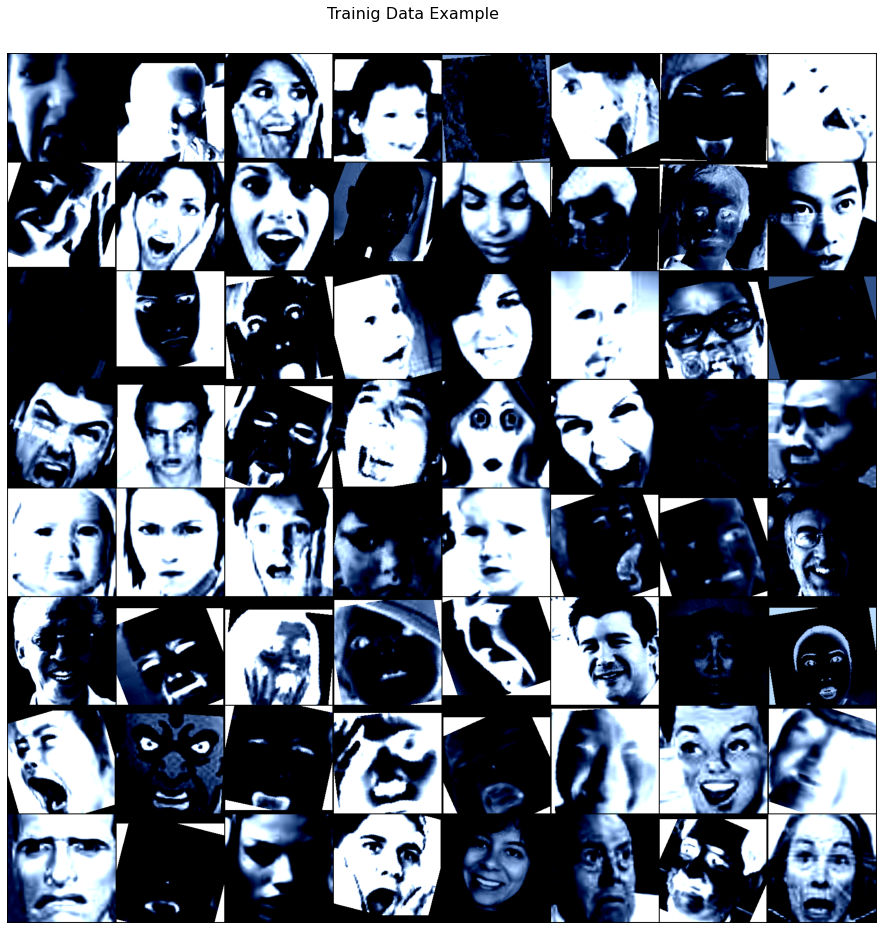

In [ ]:
from torchvision.utils import make_grid

for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(32, 16))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Trainig Data Example", y=0.92, fontsize=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


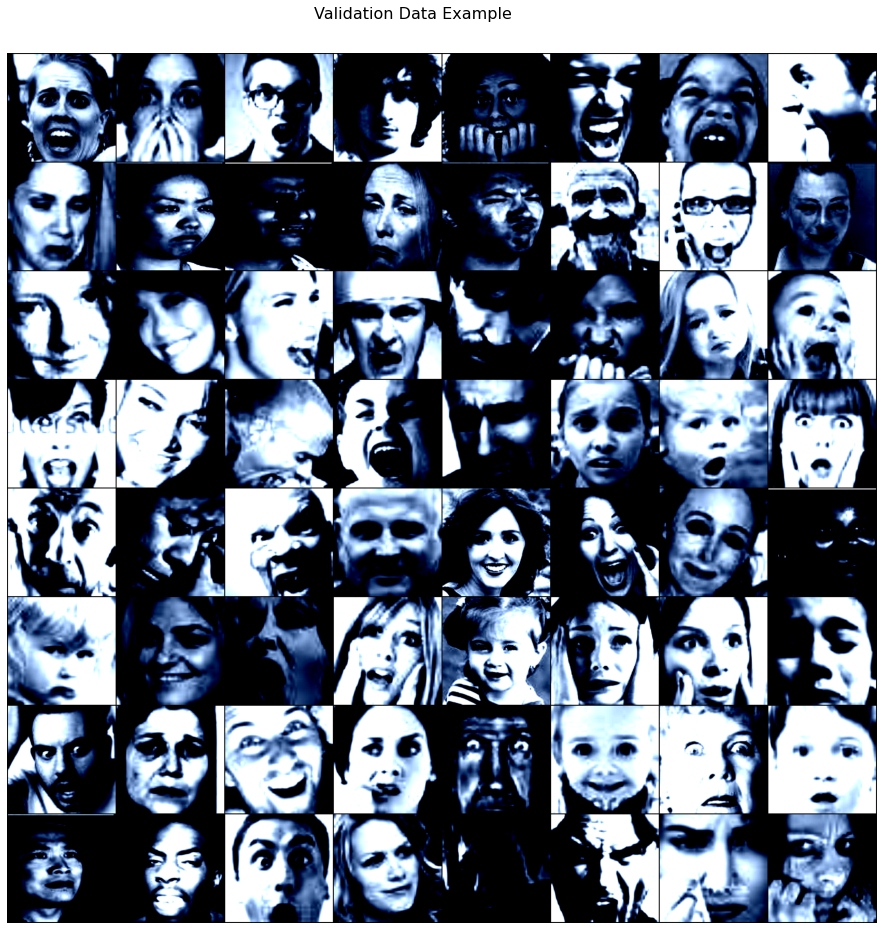

In [ ]:
from torchvision.utils import make_grid

for images, _ in valid_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(32,16))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Validation Data Example", y=0.92, fontsize=16)

## Model Building


In [ ]:
from torchvision.models import  resnet50, efficientnet_b0
FER_resnet50_fine_model = resnet50(pretrained=True)
FER_efficientnet_b0_fine_model = efficientnet_b0(pretrained=True)

FER_resnet50_base_model = resnet50(pretrained=False)
FER_efficientnet_b0_base_model = efficientnet_b0(pretrained=False)

## Model Training


In [ ]:
from torch import optim
import torch.nn.functional as F
from torch import nn


In [ ]:
from tqdm import tqdm


def training(net, n_epochs, optimizer, loss_function, train_dl, verbose=True, patience = 4):
  # Store the losses for each epoch
  loss_train_list = []
  loss_valid_list = []

  # Store the accuracy for each epoch
  acc_train_list = []
  acc_valid_list = []

  # needed for stopping
  the_last_loss = 0
  trigger_times = 0 

  import time
  training_start_time = time.time() # to know how long each epoch takes

  # Iterate over the dataset n_epochs times
  for epoch in tqdm(range(n_epochs)):
    net.train()  # net.train() will notify all your layers that you are in training mode

    train_loss = 0  # Training loss in epoch
    num_train_correct  = 0
    num_train_examples = 0

    # For each batch, pass the training examples, calculate loss and gradients and optimize the parameters
    for xb, yb in train_dl:
      optimizer.zero_grad()  # zero_grad clears old gradients from the last step

      xb = xb.to(device)
      yb = yb.to(device)

      y_hat = net(xb)  # Forward pass
      loss = loss_function(y_hat, yb)  # Calculate Loss
      
      loss.backward()  # Calculate the gradients (using backpropagation)
      optimizer.step()  # # Optimize the parameters: opt.step() causes the optimizer to take a step based on the gradients of the parameters.
      
      
      train_loss += loss.item()
      num_train_correct += (torch.max(y_hat, 1)[1] == yb).sum().item()
      num_train_examples += xb.shape[0]
    
    train_acc = num_train_correct / num_train_examples
    
    valid_loss = 0  # Validation loss in epoch
    num_val_correct  = 0
    num_val_examples = 0

    net.eval()  
    # torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed 
    # up computations but you won’t be able to backprop (which you don’t want in an evaluation script).
    with torch.no_grad():
      # Perform a prediction on the validation set  
      for xb_valid, yb_valid in valid_dl:
        xb_valid = xb_valid.to(device)
        yb_valid = yb_valid.to(device)

        y_hat = net(xb_valid)  # Forward pass
        loss = loss_function(y_hat, yb_valid)  # Calculate Loss

        valid_loss += loss.item()
        num_val_correct += (torch.max(y_hat, 1)[1] == yb_valid).sum().item()
        num_val_examples += xb_valid.shape[0]
    
    val_acc = num_val_correct / num_val_examples

    #Early stopping
    the_current_loss = valid_loss

    if the_current_loss > the_last_loss:
      trigger_times += 1

      if trigger_times >= patience:
        print('Early stopping!')
        return acc_train_list, acc_valid_list, loss_train_list, loss_valid_list

    else:
      trigger_times = 0

    the_last_loss = the_current_loss
    

    if verbose:
    # print everything nicely
      print('Epoch: {} \t Total_Time: {:.2f} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
        epoch+1,
        (time.time() - training_start_time),
        train_loss,
        valid_loss,
        train_acc * 100,
        val_acc *100
        )) 

    loss_train_list.append(train_loss)
    loss_valid_list.append(valid_loss)
    acc_train_list.append(100 * (train_acc))
    acc_valid_list.append(100 * (val_acc))

  return acc_train_list, acc_valid_list, loss_train_list, loss_valid_list

In [ ]:
# change fc to 5 classes 
FER_resnet50_fine_model.fc = nn.Linear(2048, 5)

# initalize otimizer 
optimizer = optim.Adam(FER_resnet50_fine_model.parameters(), lr=0.0003)
epochs = 20

# Create Loss Function
loss_function = nn.CrossEntropyLoss()

# bring model to gpu 
FER_resnet50_fine_model.to(device)

#start training 
res50_acc_train, res50_acc_valid, res_50_loss_train, res50_loss_valid = training(net=FER_resnet50_fine_model, n_epochs=epochs, optimizer=optimizer, loss_function=loss_function, train_dl = train_dl)

torch.save(FER_resnet50_fine_model.state_dict(), "saved_models/FER_resnet50_fine_model.pth")


  5%|▌         | 1/20 [00:32<10:08, 32.05s/it]

Epoch: 1 	 Total_Time: 32.05 	Training Loss: 111.811479 	Validation Loss: 20.863892 	Training Acc: 54.996078 	Validation Acc: 64.494876


 10%|█         | 2/20 [01:03<09:34, 31.92s/it]

Epoch: 2 	 Total_Time: 63.88 	Training Loss: 81.473345 	Validation Loss: 18.485197 	Training Acc: 68.392157 	Validation Acc: 67.935578


 15%|█▌        | 3/20 [01:35<09:01, 31.84s/it]

Epoch: 3 	 Total_Time: 95.63 	Training Loss: 69.849691 	Validation Loss: 16.729589 	Training Acc: 73.584314 	Validation Acc: 71.449488


 20%|██        | 4/20 [02:07<08:30, 31.92s/it]

Epoch: 4 	 Total_Time: 127.68 	Training Loss: 64.409936 	Validation Loss: 16.475892 	Training Acc: 76.533333 	Validation Acc: 74.670571


 25%|██▌       | 5/20 [02:39<07:58, 31.87s/it]

Epoch: 5 	 Total_Time: 159.46 	Training Loss: 58.546711 	Validation Loss: 19.345214 	Training Acc: 78.164706 	Validation Acc: 69.765739


 30%|███       | 6/20 [03:11<07:25, 31.84s/it]

Epoch: 6 	 Total_Time: 191.25 	Training Loss: 50.258330 	Validation Loss: 20.273482 	Training Acc: 80.941176 	Validation Acc: 71.376281


 35%|███▌      | 7/20 [03:43<06:54, 31.89s/it]

Epoch: 7 	 Total_Time: 223.24 	Training Loss: 51.135194 	Validation Loss: 19.378490 	Training Acc: 81.254902 	Validation Acc: 70.644217


 40%|████      | 8/20 [04:15<06:22, 31.90s/it]

Epoch: 8 	 Total_Time: 255.17 	Training Loss: 49.611328 	Validation Loss: 17.011149 	Training Acc: 81.631373 	Validation Acc: 74.011713


 45%|████▌     | 9/20 [04:46<05:50, 31.87s/it]

Epoch: 9 	 Total_Time: 286.97 	Training Loss: 44.611930 	Validation Loss: 14.689923 	Training Acc: 83.921569 	Validation Acc: 77.379209


 50%|█████     | 10/20 [05:18<05:19, 31.91s/it]

Epoch: 10 	 Total_Time: 318.98 	Training Loss: 40.744326 	Validation Loss: 20.185331 	Training Acc: 85.019608 	Validation Acc: 72.254758


 55%|█████▌    | 11/20 [05:50<04:46, 31.89s/it]

Epoch: 11 	 Total_Time: 350.81 	Training Loss: 39.714951 	Validation Loss: 19.843993 	Training Acc: 85.537255 	Validation Acc: 71.156662


 60%|██████    | 12/20 [06:22<04:14, 31.85s/it]

Epoch: 12 	 Total_Time: 382.57 	Training Loss: 37.409769 	Validation Loss: 15.562734 	Training Acc: 85.741176 	Validation Acc: 77.964861


 65%|██████▌   | 13/20 [06:54<03:43, 31.89s/it]

Epoch: 13 	 Total_Time: 414.56 	Training Loss: 38.359566 	Validation Loss: 15.716255 	Training Acc: 85.913725 	Validation Acc: 77.672035


 70%|███████   | 14/20 [07:26<03:11, 31.87s/it]

Epoch: 14 	 Total_Time: 446.37 	Training Loss: 32.682981 	Validation Loss: 14.807085 	Training Acc: 88.188235 	Validation Acc: 77.379209


 75%|███████▌  | 15/20 [07:58<02:39, 31.84s/it]

Epoch: 15 	 Total_Time: 478.16 	Training Loss: 33.330968 	Validation Loss: 17.802861 	Training Acc: 87.843137 	Validation Acc: 77.672035


 80%|████████  | 16/20 [08:30<02:07, 31.87s/it]

Epoch: 16 	 Total_Time: 510.11 	Training Loss: 31.693183 	Validation Loss: 14.694164 	Training Acc: 88.486275 	Validation Acc: 77.159590


 85%|████████▌ | 17/20 [09:01<01:35, 31.84s/it]

Epoch: 17 	 Total_Time: 541.86 	Training Loss: 29.359484 	Validation Loss: 16.539916 	Training Acc: 89.380392 	Validation Acc: 76.427526


 90%|█████████ | 18/20 [09:33<01:03, 31.84s/it]

Epoch: 18 	 Total_Time: 573.70 	Training Loss: 30.345469 	Validation Loss: 16.885861 	Training Acc: 89.254902 	Validation Acc: 78.184480


 95%|█████████▌| 19/20 [10:05<00:31, 31.88s/it]

Epoch: 19 	 Total_Time: 605.66 	Training Loss: 26.886847 	Validation Loss: 18.788376 	Training Acc: 90.305882 	Validation Acc: 76.500732


100%|██████████| 20/20 [10:37<00:00, 31.88s/it]

Epoch: 20 	 Total_Time: 637.50 	Training Loss: 26.097479 	Validation Loss: 16.014796 	Training Acc: 90.745098 	Validation Acc: 77.672035


In [ ]:
# change fc to 5 classes 
FER_resnet50_base_model.fc = nn.Linear(2048, 5)

# initalize otimizer 
optimizer = optim.Adam(FER_resnet50_base_model.parameters(), lr=0.0003)
epochs = 20

# Create Loss Function
loss_function = nn.CrossEntropyLoss()

# bring model to gpu 
FER_resnet50_base_model.to(device)

#start training 
base_res50_acc_train, base_res50_acc_valid, base_res_50_loss_train, base_res50_loss_valid = training(net=FER_resnet50_base_model, n_epochs=epochs, optimizer=optimizer, loss_function=loss_function, train_dl = train_dl)

torch.save(FER_resnet50_base_model.state_dict(), "saved_models/FER_resnet50_base_model.pth")


  5%|▌         | 1/20 [00:31<10:04, 31.84s/it]

Epoch: 1 	 Total_Time: 31.84 	Training Loss: 169.187996 	Validation Loss: 35.875334 	Training Acc: 22.619608 	Validation Acc: 21.888726


 10%|█         | 2/20 [01:03<09:34, 31.91s/it]

Epoch: 2 	 Total_Time: 63.79 	Training Loss: 163.481813 	Validation Loss: 35.161963 	Training Acc: 23.231373 	Validation Acc: 26.354319


 15%|█▌        | 3/20 [01:35<09:01, 31.85s/it]

Epoch: 3 	 Total_Time: 95.57 	Training Loss: 162.277535 	Validation Loss: 34.553271 	Training Acc: 23.701961 	Validation Acc: 26.500732


 20%|██        | 4/20 [02:07<08:30, 31.89s/it]

Epoch: 4 	 Total_Time: 127.53 	Training Loss: 160.774068 	Validation Loss: 34.727716 	Training Acc: 24.611765 	Validation Acc: 27.745242


 25%|██▌       | 5/20 [02:39<07:59, 31.96s/it]

Epoch: 5 	 Total_Time: 159.60 	Training Loss: 160.391104 	Validation Loss: 34.648569 	Training Acc: 24.407843 	Validation Acc: 26.573939


 30%|███       | 6/20 [03:11<07:26, 31.89s/it]

Epoch: 6 	 Total_Time: 191.36 	Training Loss: 157.623821 	Validation Loss: 33.323844 	Training Acc: 27.858824 	Validation Acc: 30.893119


 35%|███▌      | 7/20 [03:43<06:54, 31.91s/it]

Epoch: 7 	 Total_Time: 223.31 	Training Loss: 151.174565 	Validation Loss: 31.318006 	Training Acc: 31.309804 	Validation Acc: 37.920937


 40%|████      | 8/20 [04:15<06:22, 31.89s/it]

Epoch: 8 	 Total_Time: 255.15 	Training Loss: 139.884922 	Validation Loss: 30.049267 	Training Acc: 39.670588 	Validation Acc: 40.190337


 45%|████▌     | 9/20 [04:46<05:50, 31.86s/it]

Epoch: 9 	 Total_Time: 286.96 	Training Loss: 133.404129 	Validation Loss: 29.357232 	Training Acc: 43.513725 	Validation Acc: 44.802343


 50%|█████     | 10/20 [05:18<05:18, 31.83s/it]

Epoch: 10 	 Total_Time: 318.72 	Training Loss: 124.540424 	Validation Loss: 28.138647 	Training Acc: 48.658824 	Validation Acc: 48.462665


 55%|█████▌    | 11/20 [05:50<04:46, 31.82s/it]

Epoch: 11 	 Total_Time: 350.51 	Training Loss: 118.782724 	Validation Loss: 26.709263 	Training Acc: 50.901961 	Validation Acc: 53.513909


 60%|██████    | 12/20 [06:22<04:14, 31.81s/it]

Epoch: 12 	 Total_Time: 382.31 	Training Loss: 113.245920 	Validation Loss: 22.433541 	Training Acc: 53.003922 	Validation Acc: 59.956076


 65%|██████▌   | 13/20 [06:54<03:42, 31.80s/it]

Epoch: 13 	 Total_Time: 414.08 	Training Loss: 108.785055 	Validation Loss: 25.469433 	Training Acc: 55.827451 	Validation Acc: 55.270864


 70%|███████   | 14/20 [07:25<03:10, 31.80s/it]

Epoch: 14 	 Total_Time: 445.87 	Training Loss: 102.983174 	Validation Loss: 22.437269 	Training Acc: 59.309804 	Validation Acc: 60.248902


 75%|███████▌  | 15/20 [07:57<02:39, 31.84s/it]

Epoch: 15 	 Total_Time: 477.82 	Training Loss: 99.653939 	Validation Loss: 24.394502 	Training Acc: 60.282353 	Validation Acc: 58.125915


 80%|████████  | 16/20 [08:29<02:07, 31.89s/it]

Epoch: 16 	 Total_Time: 509.81 	Training Loss: 98.445413 	Validation Loss: 21.287805 	Training Acc: 60.768627 	Validation Acc: 62.371889


 85%|████████▌ | 17/20 [09:01<01:35, 31.91s/it]

Epoch: 17 	 Total_Time: 541.79 	Training Loss: 91.368866 	Validation Loss: 20.764785 	Training Acc: 64.235294 	Validation Acc: 62.811127


 90%|█████████ | 18/20 [09:33<01:03, 31.94s/it]

Epoch: 18 	 Total_Time: 573.79 	Training Loss: 88.386049 	Validation Loss: 19.701154 	Training Acc: 65.411765 	Validation Acc: 65.666179


 95%|█████████▌| 19/20 [10:06<00:32, 32.09s/it]

Epoch: 19 	 Total_Time: 606.24 	Training Loss: 83.715389 	Validation Loss: 19.823672 	Training Acc: 68.282353 	Validation Acc: 64.275256


100%|██████████| 20/20 [10:39<00:00, 31.96s/it]

Epoch: 20 	 Total_Time: 639.28 	Training Loss: 81.306356 	Validation Loss: 18.821143 	Training Acc: 68.658824 	Validation Acc: 66.251830


In [ ]:
# change fc to 5 classes 
FER_efficientnet_b0_fine_model.fc = nn.Linear(512, 5)


# initalize otimizer 
optimizer = optim.Adam(FER_efficientnet_b0_fine_model.parameters(), lr=0.0003)
epochs = 20

# Create Loss Function
loss_function = nn.CrossEntropyLoss()

# bring model to gpu 
FER_efficientnet_b0_fine_model.to(device)

#start training 
eff_acc_train, eff_acc_valid, eff_loss_train, eff_loss_valid = training(net=FER_efficientnet_b0_fine_model, n_epochs=epochs, optimizer=optimizer, loss_function=loss_function, train_dl = train_dl)

torch.save(FER_efficientnet_b0_fine_model.state_dict(), "saved_models/FER_efficientnet_b0_fine_model.pth")


  5%|▌         | 1/20 [00:25<08:05, 25.53s/it]

Epoch: 1 	 Total_Time: 25.54 	Training Loss: 231.273436 	Validation Loss: 25.243735 	Training Acc: 32.800000 	Validation Acc: 53.806735


 10%|█         | 2/20 [00:50<07:32, 25.16s/it]

Epoch: 2 	 Total_Time: 50.43 	Training Loss: 110.185417 	Validation Loss: 20.029032 	Training Acc: 56.501961 	Validation Acc: 64.860908


 15%|█▌        | 3/20 [01:16<07:11, 25.35s/it]

Epoch: 3 	 Total_Time: 76.02 	Training Loss: 89.534538 	Validation Loss: 19.379910 	Training Acc: 65.741176 	Validation Acc: 67.496340


 20%|██        | 4/20 [01:41<06:47, 25.45s/it]

Epoch: 4 	 Total_Time: 101.61 	Training Loss: 72.452790 	Validation Loss: 16.573616 	Training Acc: 72.501961 	Validation Acc: 72.474378


 25%|██▌       | 5/20 [02:07<06:23, 25.59s/it]

Epoch: 5 	 Total_Time: 127.46 	Training Loss: 61.500093 	Validation Loss: 15.185632 	Training Acc: 77.223529 	Validation Acc: 75.036603


 30%|███       | 6/20 [02:33<05:59, 25.66s/it]

Epoch: 6 	 Total_Time: 153.26 	Training Loss: 54.272035 	Validation Loss: 17.003197 	Training Acc: 79.764706 	Validation Acc: 73.499268


 35%|███▌      | 7/20 [02:58<05:32, 25.55s/it]

Epoch: 7 	 Total_Time: 178.58 	Training Loss: 48.453924 	Validation Loss: 15.108534 	Training Acc: 82.227451 	Validation Acc: 78.477306


 40%|████      | 8/20 [03:24<05:09, 25.78s/it]

Epoch: 8 	 Total_Time: 204.86 	Training Loss: 42.128676 	Validation Loss: 14.624228 	Training Acc: 85.145098 	Validation Acc: 77.891654


 45%|████▌     | 9/20 [03:50<04:43, 25.74s/it]

Epoch: 9 	 Total_Time: 230.52 	Training Loss: 35.448261 	Validation Loss: 14.917493 	Training Acc: 86.666667 	Validation Acc: 79.062958


 50%|█████     | 10/20 [04:16<04:19, 25.95s/it]

Epoch: 10 	 Total_Time: 256.92 	Training Loss: 33.440532 	Validation Loss: 16.366635 	Training Acc: 87.984314 	Validation Acc: 77.745242


 55%|█████▌    | 11/20 [04:43<03:54, 26.00s/it]

Epoch: 11 	 Total_Time: 283.05 	Training Loss: 29.854970 	Validation Loss: 17.277212 	Training Acc: 89.082353 	Validation Acc: 76.500732


 55%|█████▌    | 11/20 [05:08<04:12, 28.08s/it]

Early stopping!


In [ ]:
# change fc to 5 classes 
FER_efficientnet_b0_base_model.fc = nn.Linear(512, 5)


# initalize otimizer 
optimizer = optim.Adam(FER_efficientnet_b0_base_model.parameters(), lr=0.0003)
epochs = 20

# Create Loss Function
loss_function = nn.CrossEntropyLoss()

# bring model to gpu 
FER_efficientnet_b0_base_model.to(device)

#start training 
base_eff_acc_train, base_eff_acc_valid, base_eff_loss_train, base_eff_loss_valid = training(net=FER_efficientnet_b0_base_model, n_epochs=epochs, optimizer=optimizer, loss_function=loss_function, train_dl = train_dl)

torch.save(FER_efficientnet_b0_base_model.state_dict(), "saved_models/FER_efficientnet_b0_base_model.pth")


  5%|▌         | 1/20 [00:25<08:00, 25.29s/it]

Epoch: 1 	 Total_Time: 25.29 	Training Loss: 281.470712 	Validation Loss: 37.538930 	Training Acc: 20.486275 	Validation Acc: 21.815520


 10%|█         | 2/20 [00:50<07:30, 25.05s/it]

Epoch: 2 	 Total_Time: 50.17 	Training Loss: 162.869586 	Validation Loss: 35.282795 	Training Acc: 23.937255 	Validation Acc: 22.474378


 15%|█▌        | 3/20 [01:14<07:02, 24.85s/it]

Epoch: 3 	 Total_Time: 74.78 	Training Loss: 161.794800 	Validation Loss: 34.759699 	Training Acc: 24.580392 	Validation Acc: 26.061493


 20%|██        | 4/20 [01:39<06:35, 24.74s/it]

Epoch: 4 	 Total_Time: 99.35 	Training Loss: 158.734691 	Validation Loss: 34.237893 	Training Acc: 27.152941 	Validation Acc: 30.453880


 25%|██▌       | 5/20 [02:03<06:10, 24.70s/it]

Epoch: 5 	 Total_Time: 123.97 	Training Loss: 156.701476 	Validation Loss: 32.498488 	Training Acc: 29.082353 	Validation Acc: 32.796486


 30%|███       | 6/20 [02:28<05:45, 24.66s/it]

Epoch: 6 	 Total_Time: 148.55 	Training Loss: 150.220179 	Validation Loss: 31.388166 	Training Acc: 33.631373 	Validation Acc: 36.163982


 35%|███▌      | 7/20 [02:53<05:20, 24.62s/it]

Epoch: 7 	 Total_Time: 173.10 	Training Loss: 144.548761 	Validation Loss: 28.706202 	Training Acc: 37.129412 	Validation Acc: 47.730600


 40%|████      | 8/20 [03:17<04:55, 24.61s/it]

Epoch: 8 	 Total_Time: 197.69 	Training Loss: 137.421309 	Validation Loss: 26.740754 	Training Acc: 41.505882 	Validation Acc: 51.317716


 45%|████▌     | 9/20 [03:42<04:30, 24.61s/it]

Epoch: 9 	 Total_Time: 222.30 	Training Loss: 129.949874 	Validation Loss: 26.103087 	Training Acc: 45.568627 	Validation Acc: 51.098097


 50%|█████     | 10/20 [04:06<04:06, 24.62s/it]

Epoch: 10 	 Total_Time: 246.93 	Training Loss: 123.815201 	Validation Loss: 24.607107 	Training Acc: 48.972549 	Validation Acc: 56.149341


 55%|█████▌    | 11/20 [04:31<03:41, 24.59s/it]

Epoch: 11 	 Total_Time: 271.46 	Training Loss: 113.144906 	Validation Loss: 22.884790 	Training Acc: 53.819608 	Validation Acc: 58.638360


 60%|██████    | 12/20 [04:56<03:16, 24.59s/it]

Epoch: 12 	 Total_Time: 296.04 	Training Loss: 107.405943 	Validation Loss: 22.654274 	Training Acc: 56.690196 	Validation Acc: 62.079063


 65%|██████▌   | 13/20 [05:20<02:52, 24.60s/it]

Epoch: 13 	 Total_Time: 320.67 	Training Loss: 101.340817 	Validation Loss: 20.845298 	Training Acc: 59.639216 	Validation Acc: 63.103953


 70%|███████   | 14/20 [05:45<02:27, 24.60s/it]

Epoch: 14 	 Total_Time: 345.26 	Training Loss: 95.236457 	Validation Loss: 20.150476 	Training Acc: 62.321569 	Validation Acc: 65.739385


 75%|███████▌  | 15/20 [06:09<02:03, 24.60s/it]

Epoch: 15 	 Total_Time: 369.87 	Training Loss: 90.928649 	Validation Loss: 20.219118 	Training Acc: 64.376471 	Validation Acc: 67.057101


 80%|████████  | 16/20 [06:34<01:38, 24.74s/it]

Epoch: 16 	 Total_Time: 394.94 	Training Loss: 86.961567 	Validation Loss: 19.588675 	Training Acc: 65.772549 	Validation Acc: 67.935578


 85%|████████▌ | 17/20 [07:00<01:14, 24.93s/it]

Epoch: 17 	 Total_Time: 420.30 	Training Loss: 83.427009 	Validation Loss: 18.383813 	Training Acc: 68.078431 	Validation Acc: 69.180088


 90%|█████████ | 18/20 [07:25<00:49, 24.96s/it]

Epoch: 18 	 Total_Time: 445.35 	Training Loss: 80.234083 	Validation Loss: 18.441075 	Training Acc: 68.643137 	Validation Acc: 70.571010


 95%|█████████▌| 19/20 [07:51<00:25, 25.24s/it]

Epoch: 19 	 Total_Time: 471.23 	Training Loss: 76.440478 	Validation Loss: 18.595874 	Training Acc: 71.137255 	Validation Acc: 68.594436


100%|██████████| 20/20 [08:16<00:00, 24.83s/it]

Epoch: 20 	 Total_Time: 496.63 	Training Loss: 73.045678 	Validation Loss: 16.436237 	Training Acc: 72.031373 	Validation Acc: 72.254758


## Model Evaluation

### Number of trainable parameters

In [ ]:
# Number of parameters that require training 
FER_ResNet50_total_params = sum(p.numel() for p in FER_resnet50_fine_model.parameters() if p.requires_grad)
FER_EffNet_total_params = sum(p.numel() for p in FER_efficientnet_b0_fine_model.parameters() if p.requires_grad)

print(f"Pretrained ResNet50 number of parameters that require training: {FER_ResNet50_total_params} ")
print(f"Pretrained EfficientNetB0 number of parameters that require training: {FER_EffNet_total_params}")
print(f"Pretrained ResNet50 requires: {round(FER_ResNet50_total_params / FER_EffNet_total_params, 2)} times the amount of parameters to be trained")

base_FER_ResNet50_total_params = sum(p.numel() for p in FER_resnet50_base_model.parameters() if p.requires_grad)
base_FER_EffNet_total_params = sum(p.numel() for p in FER_efficientnet_b0_base_model.parameters() if p.requires_grad)

print(f"Base ResNet50 number of parameters that require training: {base_FER_ResNet50_total_params} ")
print(f"Base EfficientNetB0 number of parameters that require training: {base_FER_EffNet_total_params}")
print(f"Base ResNet50 requires: {round(base_FER_ResNet50_total_params / FER_EffNet_total_params, 2)} times the amount of parameters to be trained")



Pretrained ResNet50 number of parameters that require training: 23518277 
Pretrained EfficientNetB0 number of parameters that require training: 5291113
Pretrained ResNet50 requires: 4.44 times the amount of parameters to be trained
Base ResNet50 number of parameters that require training: 23518277 
Base EfficientNetB0 number of parameters that require training: 5291113
Base ResNet50 requires: 4.44 times the amount of parameters to be trained


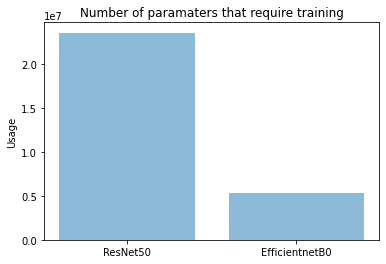

In [ ]:
# Plot number of parameters that require training: 

objects = ('ResNet50', 'EfficientnetB0')
y_pos = np.arange(len(objects))
performance = [FER_ResNet50_total_params, FER_EffNet_total_params]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Number of paramaters that require training')
plt.show()




### Loss and accuracy analysis

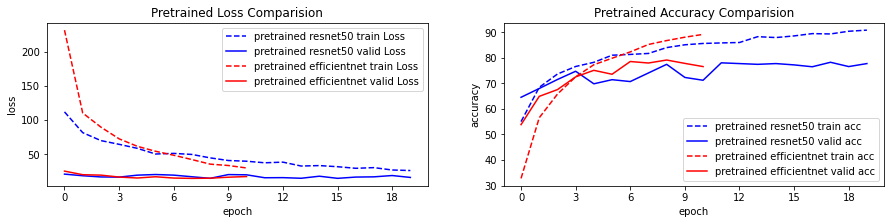

In [ ]:
import matplotlib.ticker as ticker

# Plot Loss and Accuracy over Epochs 

f = plt.figure(figsize=(15,3))


ax = f.add_subplot(121)
plt.plot(res_50_loss_train, label='pretrained resnet50 train Loss', color= "blue", ls = "--")
plt.plot(res50_loss_valid, label='pretrained resnet50 valid Loss', color= "blue")
plt.plot(eff_loss_train, label='pretrained efficientnet train Loss', color= "red", ls = "--")
plt.plot(eff_loss_valid, label='pretrained efficientnet valid Loss', color= "red")
plt.title("Pretrained Loss Comparision")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

ax = f.add_subplot(122)
plt.plot(res50_acc_train, label='pretrained resnet50 train acc', color= "blue", ls = "--")
plt.plot(res50_acc_valid, label='pretrained resnet50 valid acc', color= "blue")
plt.plot(eff_acc_train, label='pretrained efficientnet train acc', color= "red", ls = "--")
plt.plot(eff_acc_valid, label='pretrained efficientnet valid acc', color= "red")
plt.title("Pretrained Accuracy Comparision")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

#format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

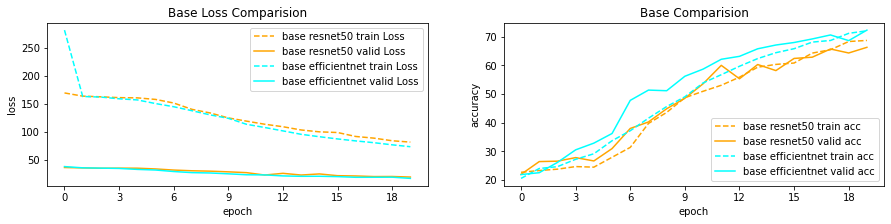

In [ ]:
import matplotlib.ticker as ticker

# Plot Loss and Accuracy over Epochs 

f = plt.figure(figsize=(15,3))


ax = f.add_subplot(121)
plt.plot(base_res_50_loss_train, label='base resnet50 train Loss', color= "orange", ls = "--")
plt.plot(base_res50_loss_valid, label='base resnet50 valid Loss', color= "orange")
plt.plot(base_eff_loss_train, label='base efficientnet train Loss', color= "cyan", ls = "--")
plt.plot(base_eff_loss_valid, label='base efficientnet valid Loss', color= "cyan")
plt.title("Base Loss Comparision")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

ax = f.add_subplot(122)
plt.plot(base_res50_acc_train, label='base resnet50 train acc', color= "orange", ls = "--")
plt.plot(base_res50_acc_valid, label='base resnet50 valid acc', color= "orange")
plt.plot(base_eff_acc_train, label='base efficientnet train acc', color= "cyan", ls = "--")
plt.plot(base_eff_acc_valid, label='base efficientnet valid acc', color= "cyan")
plt.title("Base Comparision")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

#format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

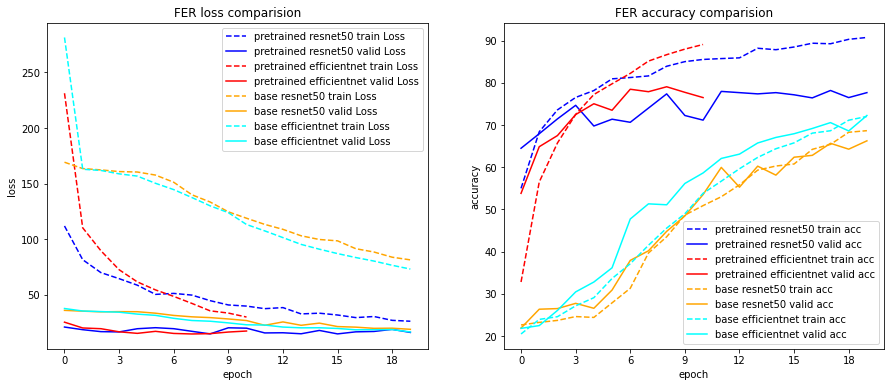

In [ ]:
import matplotlib.ticker as ticker

# Plot Loss and Accuracy over Epochs 

f = plt.figure(figsize=(15,6))


ax = f.add_subplot(121)

plt.plot(res_50_loss_train, label='pretrained resnet50 train Loss', color= "blue", ls = "--")
plt.plot(res50_loss_valid, label='pretrained resnet50 valid Loss', color= "blue")
plt.plot(eff_loss_train, label='pretrained efficientnet train Loss', color= "red", ls = "--")
plt.plot(eff_loss_valid, label='pretrained efficientnet valid Loss', color= "red")

plt.plot(base_res_50_loss_train, label='base resnet50 train Loss', color= "orange", ls = "--")
plt.plot(base_res50_loss_valid, label='base resnet50 valid Loss', color= "orange")
plt.plot(base_eff_loss_train, label='base efficientnet train Loss', color= "cyan", ls = "--")
plt.plot(base_eff_loss_valid, label='base efficientnet valid Loss', color= "cyan")
plt.title("FER loss comparision")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

ax = f.add_subplot(122)

plt.plot(res50_acc_train, label='pretrained resnet50 train acc', color= "blue", ls = "--")
plt.plot(res50_acc_valid, label='pretrained resnet50 valid acc', color= "blue")
plt.plot(eff_acc_train, label='pretrained efficientnet train acc', color= "red", ls = "--")
plt.plot(eff_acc_valid, label='pretrained efficientnet valid acc', color= "red")

plt.plot(base_res50_acc_train, label='base resnet50 train acc', color= "orange", ls = "--")
plt.plot(base_res50_acc_valid, label='base resnet50 valid acc', color= "orange")
plt.plot(base_eff_acc_train, label='base efficientnet train acc', color= "cyan", ls = "--")
plt.plot(base_eff_acc_valid, label='base efficientnet valid acc', color= "cyan")
plt.title("FER accuracy comparision")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

#format x-axis
for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

### Classification report 

In [ ]:
# get the correctly predicted lables 
def get_true_pred(model, data_loader, device = "cpu"):
  model.eval()  
  class_correct = list(0. for i in range(5))
  class_total = list(0. for i in range(5))
  y_pred = []
  y_true = []
  model.to(device)
  model.eval()  
  for x, y in data_loader:
    x, y = x.to(device), y.to(device) 
    output = model(x)
    _, pred = torch.max(output, 1)
    y_pred.append(pred.tolist())
    y_true.append(y.tolist())
    
  y_true_flat = [item for sublist in y_true for item in sublist]
  y_pred_flat = [item for sublist in y_pred for item in sublist]
  
  torch.cuda.empty_cache()  
    
  return y_true_flat, y_pred_flat

In [ ]:
res_50_y_true, res_50_y_pred = get_true_pred(FER_resnet50_fine_model, test_dl)
from sklearn.metrics import classification_report

target_names = ["angry", "fear", "happy", "sad", "suprise"]
print("Pretrained Resnet50")
print(classification_report(res_50_y_true, res_50_y_pred, target_names=target_names))

Pretrained Resnet50
              precision    recall  f1-score   support

       angry       0.72      0.81      0.76       300
        fear       0.72      0.65      0.69       166
       happy       0.86      0.81      0.83       300
         sad       0.75      0.77      0.76       300
     suprise       0.79      0.77      0.78       300

    accuracy                           0.77      1366
   macro avg       0.77      0.76      0.77      1366
weighted avg       0.78      0.77      0.77      1366



In [ ]:
eff_50_y_true, eff_50_y_pred = get_true_pred(FER_efficientnet_b0_fine_model, test_dl)
from sklearn.metrics import classification_report

target_names = ["angry", "fear", "happy", "sad", "suprise"]
print("Pretrained Efficientnet")
print(classification_report(eff_50_y_true, eff_50_y_pred, target_names=target_names))

Pretrained Efficientnet
              precision    recall  f1-score   support

       angry       0.80      0.82      0.81       300
        fear       0.70      0.67      0.68       166
       happy       0.88      0.87      0.88       300
         sad       0.84      0.74      0.79       300
     suprise       0.76      0.86      0.81       300

    accuracy                           0.80      1366
   macro avg       0.80      0.79      0.79      1366
weighted avg       0.81      0.80      0.80      1366



In [ ]:
res_50_y_true, res_50_y_pred = get_true_pred(FER_resnet50_base_model, test_dl)
from sklearn.metrics import classification_report

target_names = ["angry", "fear", "happy", "sad", "suprise"]
print("Base Resnet50")
print(classification_report(res_50_y_true, res_50_y_pred, target_names=target_names))

In [ ]:
eff_50_y_true, eff_50_y_pred = get_true_pred(FER_efficientnet_b0_base_model, test_dl)
from sklearn.metrics import classification_report

target_names = ["angry", "fear", "happy", "sad", "suprise"]
print("Base Efficientnet")
print(classification_report(eff_50_y_true, eff_50_y_pred, target_names=target_names))

# Final Thoughts
After reading the paper I had a certain expectation towards efficientnet. 
Nevertheless, I am surprised that effcientb0 has achieved better accuracy values with fewer epochs in my tests. 
In addition, it has 4.5 times less parameters, which was also noticeable in my tests by a lower training time per epoch. (This is of course strongly hardware dependent). 